<h1>IP CORE VERIFICATION</h1>

In [1]:
from pynq import Overlay
from pynq import allocate
import numpy as np
import pynq.lib.dma
import pandas as pd
import math
import time
overlay = Overlay('W13_V0.bit')
print(dir(overlay))
dma = overlay.axi_dma_0

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_deepcopy_dict_from', '_ip_map', '_register_drivers', 'axi_dma_0', 'binfile_name', 'bit_data', 'bitfile_name', 'clock_dict', 'device', 'download', 'dtbo', 'firmware_path', 'free', 'gpio_dict', 'hierarchy_dict', 'ignore_version', 'insert_dtbo', 'interrupt_controllers', 'interrupt_pins', 'ip_dict', 'is_loaded', 'load_ip_data', 'mem_dict', 'parser', 'partial', 'pr_dict', 'pr_download', 'remove_dtbo', 'reset', 'timestamp', 'zynq_ultra_ps_e_0']


In [2]:
NUM_INPUT = 128
NUM_LAYER_0 = 128
NUM_LAYER_1 = 128
NUM_OUTPUT = 1

<h1>DATA RETRIEVAL AND PREPARATION</h1>

<h2>RETRIEVE WEIGHTS AND BIASES FROM DATA FILES</h2>

In [3]:
weight_layer_0 = np.load('data/weight/weight_0.npy')
weight_layer_1 = np.load('data/weight/weight_1.npy')
weight_out = np.load('data/weight/weight_out.npy')
bias_layer_0 = np.load('data/bias/bias_0.npy')
bias_layer_1 = np.load('data/bias/bias_1.npy')
bias_out = np.load('data/bias/bias_out.npy')
df = pd.read_csv('data/train_data.csv')
training_pose = pd.Series(df.LABEL[:32]).transpose()
x_inputs = pd.Series(df.x[:32]).transpose()
y_inputs = pd.Series(df.y[:32]).transpose()
z_inputs = pd.Series(df.z[:32]).transpose()
t_inputs = pd.Series(df.t[:32]).transpose()
print(df)
print(training_pose)
print(weight_layer_0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/weight/weight_out.npy'

<h1>FPGA EVALUATION</h1>

<h2>DEFINES BUFFERS FOR TRANSFERRING PROTOCOL</h2>

In [4]:
#define buffers
#buffer for layer 0
input_weight_buffer_0 = allocate(shape=(NUM_INPUT,), dtype = np.float32)
input_weight_buffer_1 = allocate(shape=(NUM_LAYER_0,), dtype = np.float32)
output_weight_buffer = allocate(shape=(NUM_LAYER_1,), dtype = np.float32)

input_bias_buffer_0 = allocate(shape=(NUM_LAYER_0,), dtype = np.float32)
input_bias_buffer_1 = allocate(shape=(NUM_LAYER_1,), dtype = np.float32)
output_bias_buffer = allocate(shape=(NUM_OUTPUT,), dtype = np.float32)

<h2>LOAD WEIGHTS AND BIASES TO FPGA</h2>

In [5]:
#Send weights for layer 0
for i in range(NUM_LAYER_0):
    for j in range(NUM_INPUT):
        input_weight_buffer_0[j] = weight_layer_0[i][j]
    #print(input_weight_buffer_0)
    dma.sendchannel.transfer(input_weight_buffer_0)
    dma.sendchannel.wait()
    
#Send weights for layer 1    
for i in range(NUM_LAYER_1):
    for j in range(NUM_LAYER_0):
        input_weight_buffer_1[j] = weight_layer_1[i][j]
    #print(input_buffer_1)
    dma.sendchannel.transfer(input_weight_buffer_1)
    dma.sendchannel.wait()
    
#Send weights for output layer
for i in range(NUM_OUTPUT):
    for j in range(NUM_LAYER_0):
        output_weight_buffer[j] = weight_out[i][j]
    #print(output_weight_buffer)
    dma.sendchannel.transfer(output_weight_buffer)
    dma.sendchannel.wait()
    
#Send biases for layer 0
for i in range(NUM_LAYER_0):
    input_bias_buffer_0[i] = bias_layer_0[i]
dma.sendchannel.transfer(input_bias_buffer_0)
dma.sendchannel.wait()

#Send biases for layer 1
for i in range(NUM_LAYER_1):
    input_bias_buffer_1[i] = bias_layer_1[i]
dma.sendchannel.transfer(input_bias_buffer_1)
dma.sendchannel.wait()

#Send biases for output layer
for i in range(NUM_OUTPUT):
    output_bias_buffer[i] = bias_out[i]
dma.sendchannel.transfer(output_bias_buffer)
#print(output_bias_buffer)
dma.sendchannel.wait()

RuntimeError: DMA channel not started

In [20]:
#input_buffer = allocate(shape=(NUM_INPUT,), dtype = np.float32)
#output_buffer = allocate(shape=(NUM_OUTPUT,), dtype = np.float32)

def fpga_pos_evaluation():
    input_buffer = allocate(shape=(NUM_INPUT,), dtype = np.float32)
    output_buffer = allocate(shape=(NUM_OUTPUT,), dtype = np.float32)
    for i in range(32):
        input_buffer[i] = x_inputs[i]
    for i in range(32):
        input_buffer[i + 32] = y_inputs[i]
    for i in range(32):
        input_buffer[i + 64] = z_inputs[i]  
    for i in range(32):
        input_buffer[i + 96] = t_inputs[i]
    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    return output_buffer
#fpga_pos = np.zeros(1)
#fpga_pos = np.row_stack(fpga_pos_evaluation())


In [21]:
#print(fpga_pos[0][0])

<h1>CPU IMPLEMENTATION</h1>

In [22]:
def sigmoid(x):
    if (x > 100):
        return 1
    elif (x < -100):
        return 0
    else:
        return (1/(1+math.exp(float(-x))))

def cpu_evaluation():
    inputs = np.zeros(NUM_INPUT)
    layer_0 = np.zeros(NUM_LAYER_0)
    layer_1 = np.zeros(NUM_LAYER_1)
    outputs = np.zeros(NUM_OUTPUT)
    for i in range(32):
        inputs[i] = x_inputs[i]
    for i in range(32):
        inputs[i + 32] = y_inputs[i]
    for i in range(32):
        inputs[i + 64] = z_inputs[i]  
    for i in range(32):
        inputs[i + 96] = t_inputs[i]
    cpu_res = np.zeros(1)
    for i in range(NUM_LAYER_0):
        layer_0[i] = np.dot(inputs, weight_layer_0[i]) + bias_layer_0[i]
        layer_0[i] = sigmoid(layer_0[i])
    for i in range(NUM_LAYER_1):
        layer_1[i] = np.dot(layer_0, weight_layer_1[i]) + bias_layer_1[i]
        layer_1[i] = sigmoid(layer_1[i])
    for i in range(NUM_OUTPUT):
        outputs[i] = np.dot(layer_1, weight_out[i]) + bias_out[i]
        outputs[i] = sigmoid(outputs[i])
    return outputs
    

<h2>POWER METRICS</h2>

In [23]:
rails = pynq.get_rails()
recorder1 = pynq.DataRecorder(rails['PSINT_FP'].power, rails['PSPLL'].power)
recorder2 = pynq.DataRecorder(rails['PSINT_FP'].power, rails['PSPLL'].power)

<h2>FPGA PERFORMANCE</h2>

In [24]:
fpga_time = time.time()
recorder1.reset()
fpga_res = np.zeros(1)
with recorder1.record(0.00001):
    time.sleep(1)
    recorder1.mark()
    timestart = time.time()
    fpga_res = np.row_stack(fpga_pos_evaluation())
    timeend = time.time()
    recorder1.mark()
    time.sleep(1)
    fpga_time = timeend-timestart
print('Time taken = ' + str(fpga_time))    
recorder1.frame.plot(subplots=True)
print(fpga_res)
#fpga_res = np.argmax(fpga_res, axis=-1)

RuntimeError: DMA channel not started

<h2>CPU PERFORMANCE</h2>

Time taken = 0.03504323959350586
[1.]


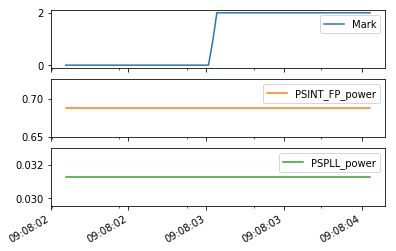

In [25]:
cpu_time = time.time()

recorder2.reset()
with recorder2.record(0.01):
    time.sleep(1)
    recorder2.mark()
    timestart = time.time()
    cpu_res = cpu_evaluation()
    timeend = time.time()
    recorder2.mark()
    time.sleep(1)
    cpu_time = timeend-timestart
print('Time taken = ' + str(cpu_time))    
recorder2.frame.plot(subplots=True)
print(cpu_res)
#cpu_res = np.argmax(cpu_res, axis=-1)